In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/My Drive/seminar")
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
aventador.jpg			       nature.jpg
dali.jpg			       parrot.jpg
dinamo.jpg			       resnet_v1_50.ckpt
dogs.png			       resnet_v1_50_frozen.pb
eiffel.jpg			       sealion.png
galaxy.jpg			       sky.JPG
imagenet_comp_graph_label_strings.txt  starry_night.jpg
inception_v4.pb			       tensorflow_inception_graph.pb
LICENSE				       waterfall.jpg
logs				       zagreb.jpg


In [0]:
import tensorflow as tf

class CNNModel():
    def __init__(self, pb_file):
        self.graph = tf.Graph()

        with tf.gfile.GFile(pb_file, "rb") as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())

        with self.graph.as_default() as graph:
            tf.import_graph_def(graph_def)
            
    def get_layer_tensor_for_name(self, layer_name):
        return self.graph.get_tensor_by_name(layer_name)
            
    def get_gradient_for_layer(self, layer, input_layer):
        with self.graph.as_default():
            layer_mean = tf.reduce_mean(tf.square(layer))
            gradient = tf.gradients(layer_mean, input_layer)
            return gradient
          
    def get_gradient_for_logit(self, logits, index, input_layer):
        with self.graph.as_default():
            loss = tf.losses.mean_squared_error(tf.one_hot(index, logits.shape[1]), logits[0])
            #loss = (tf.one_hot(index, logits.shape[1]) - logits[0])**2
            gradient2 = tf.gradients(loss, input_layer)
            return gradient2
        
    def print_all_variables(self):
	    for v in self.graph.get_operations():
		    print(v.name, v.values())
          

In [0]:
from PIL import Image
import numpy as np

class ImageHandler:
    def load(image_path):
        im = Image.open(image_path)
        im = im.convert("RGB")
        im.load()
        return np.asarray(im, dtype="float32")
    
    def normalize(image):
        min_value = np.min(image)
        max_value = np.max(image)
        normalized = (image - min_value) / (max_value - min_value)
        return normalized
      
    def resize(image, scale=None, size=None):
        new_size = size if size else np.int32(np.array(image.shape[0:2]) * scale)
      
        with tf.Session() as sess:
            resized = tf.image.resize(image, new_size)
            return sess.run(resized)
          
    def draw(image):
        #image = np.clip(image, 0, 255)
        image = image.astype(np.uint8)
        display(Image.fromarray(image))
        
    def jitter(image, jx=None,  jy=None, max_jitter=32):
        if jx == None or jy == None:
            jx, jy = np.random.randint(-max_jitter, max_jitter + 1, 2)
            
        first = np.roll(image, jy, 1)
        return np.roll(first, jx, 0), jx, jy

In [0]:
from scipy.ndimage import gaussian_filter

def process_image(image, model, layer, input_layer, num_iter, step):
    image_copy = np.array(image)
    layer_grad = model.get_gradient_for_layer(layer, input_layer)
    
    with tf.Session(graph=model.graph) as sess:
        print("iter", end=" ")
        for i in range(num_iter):
            print(i, end=" ")
            if i%10 == 0: print()
            
            grad = sess.run(layer_grad, feed_dict = {input_layer : np.array([image_copy])})
            grad = grad[0][0]
            
            sigma = (i + 1) * 0.5
            '''grad_smooth1 = gaussian_filter(grad, sigma=sigma)
            grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
            grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
            grad_smooth = (grad_smooth1 + grad_smooth2 + grad_smooth3)
            grad = grad_smooth / np.std(grad_smooth)'''
            
            grad = gaussian_filter(grad, sigma=sigma)
            grad /= np.std(grad)
            
            image_copy += grad * step
            image_copy = np.clip(image_copy, 0, 255)
        print()
    
    return image_copy

In [5]:
import scipy.ndimage as nd

def create_octaves(image, num_octaves, scale):
    octaves = [image]
    for i in range(num_octaves - 1):
        octave_i = ImageHandler.resize(octaves[0], scale=scale)
        #octave_i = nd.zoom(octaves[0], (scale, scale, 1), order=1)
        octaves.insert(0, octave_i)
    
    return octaves
  
img = ImageHandler.load("eiffel.jpg")
octaves = create_octaves(img, 8, 0.8)

'''for o in octaves:
    print(o.shape)
    ImageHandler.draw(o)'''
    

'for o in octaves:\n    print(o.shape)\n    ImageHandler.draw(o)'

In [0]:
def process_image3(image, logits, index, input_layer, num_iter, step, num_octaves, scale):
    octaves = create_octaves(image, num_octaves, scale)
    
    result = octaves[-1]
    details = np.zeros(octaves[0].shape)
    
    layer_grad = model.get_gradient_for_logit(logits, index, input_layer)
    
    sess = tf.Session(graph=model.graph)
    
    for i in range(num_octaves):
        print("octave:", i)
        if i != 0:
            details = ImageHandler.resize(details, size=octaves[i].shape[0:2])
            
        #ImageHandler.draw(octaves[i])
        
        result = octaves[i] + details
        
        for j in range(num_iter):
            print(j, end=" ")
            
            result, jx, jy = ImageHandler.jitter(result)
            
            grad = sess.run(layer_grad, feed_dict = {input_layer : np.array([result])})
            grad = grad[0][0]

            sigma = j/num_iter * 2
            grad = gaussian_filter(grad, sigma=sigma)
            grad /= np.std(grad) 

            result -= grad * step
            
            result, _, _ = ImageHandler.jitter(result, -jx, -jy)
            result = np.clip(result, 0, 255)
         
        print()
        details = result - octaves[i]
        #ImageHandler.draw(result)
    
    sess.close()
    
    return result
  

    

In [0]:
def process_image2(image, layer, input_layer, num_iter, step, num_octaves, scale):
    octaves = create_octaves(image, num_octaves, scale)
    
    result = octaves[-1]
    details = np.zeros(octaves[0].shape)
    
    layer_grad = model.get_gradient_for_layer(layer, input_layer)
    
    sess = tf.Session(graph=model.graph)
    
    for i in range(num_octaves):
        print("octave:", i)
        if i != 0:
            details = ImageHandler.resize(details, size=octaves[i].shape[0:2])
            
        #ImageHandler.draw(octaves[i])
        
        result = octaves[i] + details
        
        for j in range(num_iter):
            print(j, end=" ")
            
            result, jx, jy = ImageHandler.jitter(result)
            
            grad = sess.run(layer_grad, feed_dict = {input_layer : np.array([result])})
            grad = grad[0][0]

            sigma = j/num_iter * 2
            grad = gaussian_filter(grad, sigma=sigma)
            grad /= (np.std(grad) + 1e-10)

            result += grad * step
            
            result, _, _ = ImageHandler.jitter(result, -jx, -jy)
            result = np.clip(result, 0, 255)
         
        print()
        details = result - octaves[i]
        #ImageHandler.draw(result)
    
    sess.close()
    
    return result

460
octave: 0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
octave: 1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
octave: 2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
octave: 3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 

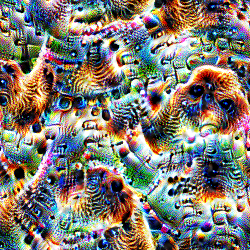

In [63]:
#model = CNNModel("inception_v4.pb")
model = CNNModel("tensorflow_inception_graph.pb")
#img = ImageHandler.load("starry_night.jpg")
img = np.random.randint(0, 256, (250, 250, 3))
index = np.random.randint(0, 832)
print(index)
layer = model.graph.get_tensor_by_name("import/mixed5a:0")[:,:,:,index]
input_layer = model.graph.get_tensor_by_name("import/input:0")

res = process_image2(img, layer, input_layer, num_iter=100, step=10, num_octaves=5, scale=0.95)
ImageHandler.draw(res)


825
octave: 0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
octave: 1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
octave: 2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
octave: 3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
octave: 4
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
octave: 5
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
octave: 6
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
octave: 7
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 


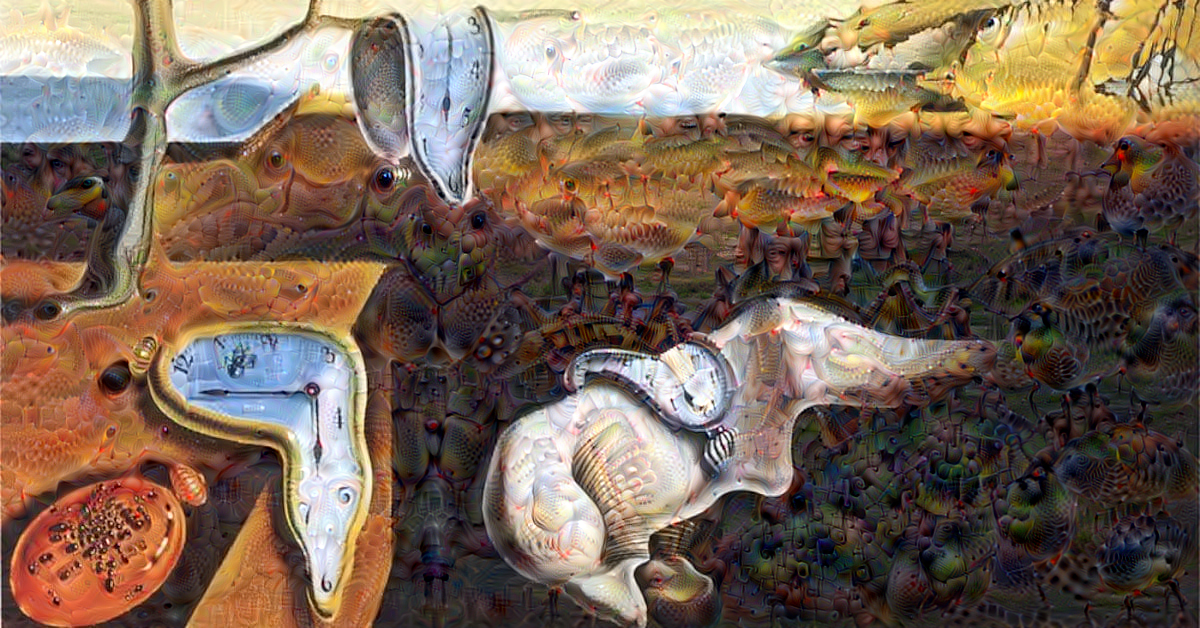

In [12]:
#model = CNNModel("inception_v4.pb")
model = CNNModel("tensorflow_inception_graph.pb")
img = ImageHandler.load("dali.jpg")
#ImageHandler.draw(img)

index = np.random.randint(0, 832)
print(index)

layer = model.graph.get_tensor_by_name("import/mixed5a:0")
input_layer = model.graph.get_tensor_by_name("import/input:0")

res = process_image2(img, layer, input_layer, num_iter=35, step=1, num_octaves=8, scale=0.95)
ImageHandler.draw(res)